# Fish landings timeseries

## Background

The eastern boundary upwelling system off Peru is the most productive upwelling system in the world and has contributed to 10% of the global fish landings. However, small pelagic fish in this region are succeptible to strong interannual variability and are prone to collapse. Predicting the temporal variability of these fishes is crucial for a precautionary fisheries management for Peru.

## Methods and results

This notebook predicts fish landings off Peru from a yearly timeseries using an RNN. The dataset was downloaded from the Sea Around Us project: https://www.seaaroundus.org/data/#/eez/604?chart=catch-chart&dimension=taxon&measure=tonnage&limit=10

Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn import metrics

2023-07-21 16:35:47.769711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and group data

In [3]:
data = pd.read_table("SAU-EEZ-604-v50-1.csv", sep = ",")

In [5]:
data

,area_name,area_type,data_layer,uncertainty_score,year,scientific_name,common_name,functional_group,commercial_group,fishing_entity,fishing_sector,catch_type,reporting_status,gear_type,end_use_type,tonnes,landed_value
0,Peru,eez,Reconstructed domestic catch,3.0,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Peru,Industrial,Landings,Reported,purse seine,Direct human consumption,43.956000,12834.297495
1,Peru,eez,Reconstructed domestic catch,3.0,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Peru,Industrial,Landings,Reported,purse seine,Fishmeal and fish oil,0.022000,0.000152
2,Peru,eez,Reconstructed domestic catch,3.0,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Peru,Industrial,Landings,Reported,purse seine,Other,0.022000,0.000152
3,Peru,eez,Reconstructed domestic catch,3.0,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Peru,Subsistence,Landings,Unreported,subsistence fishing gear,Direct human consumption,685.000000,200006.683600
4,Peru,eez,Reconstructed domestic catch,3.0,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Peru,Artisanal,Landings,Reported,small scale gillnets,Direct human consumption,486.513000,142052.338187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67380,Peru,eez,Assigned Tuna RFMO catch,NaN,2019,Xiphias gladius,Swordfish,Large pelagics (>=90 cm),Tuna & billfishes,Unknown Fishing Country,Industrial,Landings,Reported,longline,Direct human consumption,59.822133,203547.065690
67381,Peru,eez,Assigned Tuna RFMO catch,NaN,2019,Carcharhinus falciformis,Silky shark,Large sharks (>=90 cm),Sharks & rays,Unknown Fishing Country,Industrial,Discards,Unreported,longline,NaN,0.164683,NaN
67382,Peru,eez,Assigned Tuna RFMO catch,NaN,2019,Carcharhinus longimanus,Oceanic whitetip shark,Large sharks (>=90 cm),Sharks & rays,Unknown Fishing Country,Industrial,Discards,Unreported,longline,NaN,0.085557,NaN
67383,Peru,eez,Assigned Tuna RFMO catch,NaN,2019,Prionace glauca,Blue shark,Large sharks (>=90 cm),Sharks & rays,Unknown Fishing Country,Industrial,Discards,Unreported,longline,NaN,173.628328,NaN


Pick your species, we tested with anchovy and with the Pacific chub mackerel

In [5]:
anc = data[data["common_name"] == "Anchoveta"]
#anc = data[data["common_name"] == "Pacific chub mackerel"]

In [6]:
anc

,area_name,area_type,data_layer,uncertainty_score,year,scientific_name,common_name,functional_group,commercial_group,fishing_entity,fishing_sector,catch_type,reporting_status,gear_type,end_use_type,tonnes,landed_value
141,Peru,eez,Reconstructed domestic catch,3.0,1950,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Peru,Industrial,Landings,Reported,purse seine,Fishmeal and fish oil,500.000000,2.043841e+02
675,Peru,eez,Reconstructed domestic catch,3.0,1951,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Peru,Industrial,Discards,Unreported,purse seine,NaN,1785.000000,NaN
676,Peru,eez,Reconstructed domestic catch,3.0,1951,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Peru,Industrial,Landings,Reported,purse seine,Fishmeal and fish oil,7400.000000,3.691898e+03
677,Peru,eez,Reconstructed domestic catch,3.0,1951,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Peru,Industrial,Landings,Unreported,purse seine,Fishmeal and fish oil,2940.000000,1.466781e+03
1217,Peru,eez,Reconstructed domestic catch,3.0,1952,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Peru,Industrial,Discards,Unreported,purse seine,NaN,122.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67172,Peru,eez,Inferred foreign catch,NaN,2019,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Chile,Industrial,Landings,Reported,purse seine,Fishmeal and fish oil,77846.232188,2.145680e+07
67173,Peru,eez,Inferred foreign catch,NaN,2019,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Chile,Industrial,Landings,Reported,purse seine,Other,53.114700,1.464003e+04
67174,Peru,eez,Inferred foreign catch,NaN,2019,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Chile,Industrial,Landings,Unreported,purse seine,Direct human consumption,406.691968,6.033318e+04
67175,Peru,eez,Inferred foreign catch,NaN,2019,Engraulis ringens,Anchoveta,Small pelagics (<30 cm),Anchovies,Chile,Industrial,Landings,Unreported,purse seine,Fishmeal and fish oil,1115.430018,3.074465e+05


Aggregate by year

In [8]:
anc_yearly = anc.groupby("year").sum()
#anc_yearly.values.shape
anc_yearly

/var/folders/w8/nck875wx27sbq527kjwtb8csj2nk90/T/ipykernel_70878/1555873339.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  anc_yearly = anc.groupby("year").sum()


,uncertainty_score,tonnes,landed_value
year,,,
1950,3.0,5.000000e+02,2.043841e+02
1951,9.0,1.212500e+04,5.158679e+03
1952,9.0,1.614200e+04,8.288396e+03
1953,9.0,3.779500e+04,1.614174e+04
1954,9.0,4.388600e+04,2.074957e+04
...,...,...,...
2015,15.0,4.326314e+06,6.867954e+08
2016,15.0,3.295783e+06,7.863135e+08
2017,15.0,3.745256e+06,7.394040e+08


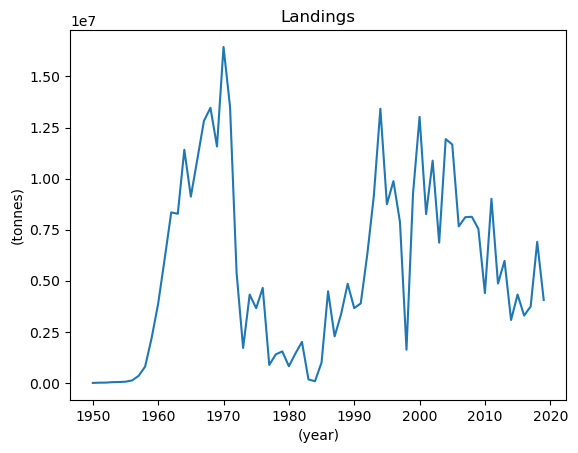

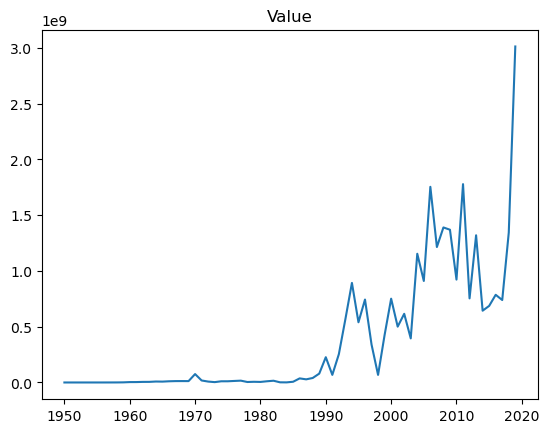

In [10]:
plt.plot(range(1950,2020),anc_yearly.values[:,1])
#plt.title("Anchovy landings")
plt.title("Landings")
plt.xlabel("(year)")
plt.ylabel("(tonnes)")
plt.show()
plt.plot(range(1950,2020),anc_yearly.values[:,2])
plt.title("Value")
plt.show()

## RNN

Split the data

In [15]:
time = np.array(range(1950,2020))
series = anc_yearly.values[:,1] #  A learning rate of 4e-4 helps
learning_rate = 4e-4
time_step = 50 # We slplit in year 2000
window_size = 5

In [16]:
def train_val_split(time, series, time_step):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(time,series,time_step)

In [17]:
time_valid

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

Get the window size. To test, get windows of 1

In [18]:
def windowed_dataset(series, window_size, batch_size=5, shuffle_buffer=1):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
# Apply the transformation to the training set
dataset = windowed_dataset(series_train, window_size)

Model

In [19]:
def create_model(window_size):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)])
#    model.compile(loss="mse",
#                  optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5))
    return model

In [20]:
model = create_model(window_size)
model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.fit(dataset, epochs=1000)

Epoch 1/1000


2023-07-21 16:40:26.819006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50]
	 [[{{node Placeholder/_0}}]]
2023-07-21 16:40:26.819873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50]
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 1s 64ms/step - loss: 94072442191872.0000
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 89875135070208.0000
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 85926248185856.0000
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 82242911076352.0000
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 78687114362880.0000
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 75299911892992.0000
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 72159401607168.0000
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 69072905568256.0000
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 66156228509696.0000
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 63372410224640.0000
Epoch 11/1000
9/9 [==============================] - 0s 2ms/step - loss: 60691562102784.000

Change the learning rate

In [16]:
def lr_scheduler(epoch, lr):
    if epoch > 100:
        lr =4e-3
    if epoch > 500:
        lr = 4e-4
    return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]

Try again

In [17]:
model.fit(dataset, epochs=1000, callbacks=callbacks)

Epoch 1/1000

Epoch 00001: LearningRateScheduler setting learning rate to 0.03999999910593033.
9/9 [==============================] - 0s 2ms/step - loss: 5931887243558912.0000
Epoch 2/1000

Epoch 00002: LearningRateScheduler setting learning rate to 0.03999999910593033.
9/9 [==============================] - 0s 3ms/step - loss: 6908959017402368.0000
Epoch 3/1000

Epoch 00003: LearningRateScheduler setting learning rate to 0.03999999910593033.
9/9 [==============================] - 0s 2ms/step - loss: 5716571943075840.0000
Epoch 4/1000

Epoch 00004: LearningRateScheduler setting learning rate to 0.03999999910593033.
9/9 [==============================] - 0s 1ms/step - loss: 5351523345235968.0000
Epoch 5/1000

Epoch 00005: LearningRateScheduler setting learning rate to 0.03999999910593033.
9/9 [==============================] - 0s 2ms/step - loss: 5191195437301760.0000
Epoch 6/1000

Epoch 00006: LearningRateScheduler setting learning rate to 0.03999999910593033.
9/9 [====================

Forecast

In [21]:
def generate_forecast(series=series, split_time=time_step, window_size=window_size):
    forecast = []
    #print(forecast)
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
        #print(forecast)
    forecast = forecast[split_time-window_size:]
    #print(forecast)
    results = np.array(forecast)[:, 0, 0]
    #print(results)
    return results


1/1 [==============================] - 0s 20ms/step


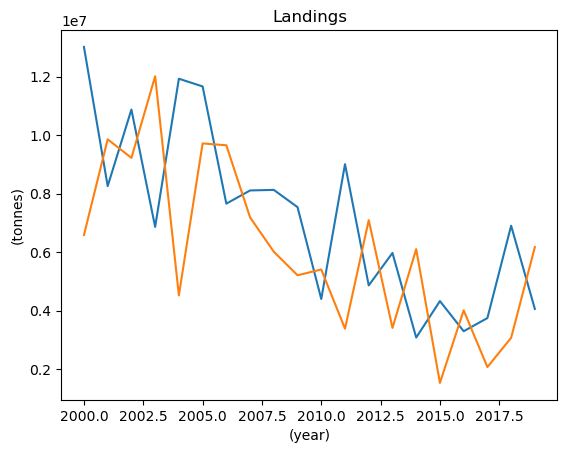

In [23]:
dnn_forecast = generate_forecast(series, time_step, window_size)

plt.plot(time_valid, series_valid)
plt.plot(time_valid, dnn_forecast)
#plt.title("Anchovy landings")
plt.title("Landings")
plt.xlabel("(year)")
plt.ylabel("(tonnes)")
plt.show()


## Conclusion

Our simple RNN manages to predict the declining tren of anchovy landings. However, there is a shift in the predictions with respect to the real values.